## Programming Assignment 3
* CSCI-5930 ML Spring 2019
* Author: Bhuwan Sapkota

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score
import itertools
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import sys
import operator
import math

In [2]:
#Load the CSV. And it does have a header
datasetA_OR = pd.read_csv('Set-A.X.csv')
datasetATarget_OR = pd.read_csv('Set-A.y.csv', header = None)

datasetA_OR = datasetA_OR.drop(['domain1','state1','zip1','indicator2','flag4','indicator1','field2'], axis=1)

## Task 1 : Logistic Regression based Classifier (LR)

In [3]:
datasetA = datasetA_OR.loc[range(0,30000)]
datasetATarget = datasetATarget_OR.loc[range(0,30000)]

#changing to array
X = datasetA.values
y = datasetATarget.values
y = y.flatten()

XTrain, XTest, yTrain, yTest = train_test_split(X , y, test_size=0.2)

yTest.flatten()
yTrain.flatten()

#fit_transform use the statistics from given data and normalize it
scalar = StandardScaler()
scalar.fit(XTrain)                    # using XTrain data to normalization

XTrain = scalar.transform(XTrain)
XTest = scalar.transform(XTest)

### 1.1 Use a 10-fold cross validation strategy to obtain the best set of hyper-parameter values of the logisticregression. Please report a discussion why you would choose the values. (On the training set)

In [4]:
def predict_probs(X, theta):
    return sigmoid(np.dot(X, theta))

def predict(X, theta, threshold=0.5):
    return predict_probs(X, theta) >= threshold

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def loss(h, y): 
    return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()

In [5]:
#defining logistic gradient_decent which will use the mini batch  

def LGD_MinBatch(XTrain, yTrain, thetas, epochs=1000, learningRate=0.5, batchSize = 128):
    theta= thetas
    m = len(XTrain)
    XRand = np.random.permutation(XTrain)
    yRand = np.random.permutation(yTrain)
    prevLoss = sys.maxsize
#     flg = False
    
    for it in range(epochs):
        for i in range (0,m, batchSize):
            XcurrBatch = XTrain[i:i+batchSize]
            ycurrBatch = yTrain[i:i+batchSize] 
            y_hat = np.dot(XcurrBatch,theta)
            h = sigmoid(y_hat)
            err = h - ycurrBatch.flatten()
            gradient = np.dot(XcurrBatch.T,err )
            theta = theta -  ((1/m) * learningRate * (gradient))
#         if(it % 100 == 0):
#             h_ = predict(XTrain, theta)
#             l_ = loss(h_,yTrain)
#             print(f'loss: ' + str(l_))
#             if abs(prevLoss - l_) > 0.000001:
#                 prevLoss = l_
#             else:
#                 flg = True  # it will break the epoch loop if it is no logner converging or convergin too slow
#         if flg:
#             break
    return theta

In [6]:
XTrainWB = np.insert(XTrain, 0, values=1, axis=1)
XTestWB = np.insert(XTest, 0, values=1, axis=1)

In [7]:
h_p = [[100,0.01,32],[1000,0.5,128],[500,0.1,1028],[2000,0.05,64],[1500,0.3,256]]

In [8]:
def bestHPs(hps):
    besthp = hps[0]
    minAvrLoss = sys.maxsize
    for hp in hps:
        Weights = np.zeros(XTrainWB.shape[1])
        # for epoch in range(5):
        kf = KFold(n_splits=10, shuffle=True)
        kf.get_n_splits(XTrainWB, yTrain)  
        kf.split(XTrainWB)                  # this works for target variables too
        ls = []
        for train_index, test_index in kf.split(XTrainWB):
            X_train, X_validation = XTrainWB[train_index], XTrainWB[test_index]
            y_train, y_validation = yTrain[train_index], yTrain[test_index]
            Weights = LGD_MinBatch(X_train, y_train, Weights,hp[0], hp[1], hp[2])
            pred_P = predict_probs(X_validation, Weights)
            l_ = loss(pred_P,y_validation)
            ls.append(l_)
        currAvrloss = np.mean(ls)
        print('Average loss: '+ str(currAvrloss)+ ' for epoch: '+ str(hp[0]) 
              + ' Learning Rate: '+ str(hp[1]) + ' and Batch Size: '+ str(hp[2]))
        if (currAvrloss < minAvrLoss):
            minAvrLoss = currAvrloss
            bestHPs = hp
    return bestHPs

#         RMSEArr.append(np.sqrt(np.mean((pred - y_validation )**2)))
#     print('Average RMS Error: ' + str(np.mean(RMSEArr)))

In [9]:
bestHyperPara = bestHPs(h_p)

Average loss: 0.2513458078000394 for epoch: 100 Learning Rate: 0.01 and Batch Size: 32
Average loss: 0.04813812980474631 for epoch: 1000 Learning Rate: 0.5 and Batch Size: 128
Average loss: 0.05070668636196057 for epoch: 500 Learning Rate: 0.1 and Batch Size: 1028
Average loss: 0.04895155812544986 for epoch: 2000 Learning Rate: 0.05 and Batch Size: 64
Average loss: 0.047880955494461606 for epoch: 1500 Learning Rate: 0.3 and Batch Size: 256


In [10]:
# now train the data based one above parameters
Weights = np.zeros(XTrainWB.shape[1])  # initializing with all zerors
Weights = LGD_MinBatch(XTrainWB, yTrain, Weights, bestHyperPara[0], bestHyperPara[1], bestHyperPara[2])

### 1.2 Train the classifier on the training set, and report the training confusion matrix, accuracy, precision, recall, F1-score, the ROC curve and the corresponding AUC score.

In [11]:
pred = predict(XTrainWB, Weights)

In [12]:
class_names = ['notFraud', 'Fraud']

In [13]:
def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#             print("Normalized confusion matrix\n============================")
#         else:
#             print('Confusion matrix, without normalization\n============================')

#         print(cm)
#         print("\n")

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()

def printAPRF(y,p,c_names):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
#     for i in range(len(yTest)):
    for i in range(len(y)):
        if y[i]==1 and p[i]==1:
            TP = TP + 1
        elif y[i]==0 and p[i]==0:
            TN = TN + 1
        elif y[i]==1 and p[i]==0:
            FN = FN + 1
        elif y[i]==0 and p[i]==1:
            FP = FP + 1
    if TP == 0:
        TP = 0.00000001
    if TN == 0:
        TN = 0.00000001
    if FP == 0:
        FP = 0.00000001
    if FN == 0:
        FN = 0.00000001
    acc = (TP+TN)/(TP+FP+TN+FN)
    print("Acc = %.2f" % acc)

    rec = TP/(TP+FN)
    print("rec = %.2f" % rec)

    prec = TP/(TP+FP)
    print("prec = %.2f" % prec)

    f1 = 2*prec*rec/(prec+rec)
    print("f1 = %.2f" %f1)
    
def calculateAndPlot(y,p,c_names):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
#     for i in range(len(yTest)):
    for i in range(len(p)):
        if y[i]==1 and p[i]==1:
            TP = TP + 1
        elif y[i]==0 and p[i]==0:
            TN = TN + 1
        elif y[i]==1 and p[i]==0:
            FN = FN + 1
        elif y[i]==0 and p[i]==1:
            FP = FP + 1
    if TP == 0:
        TP = 0.00000001
    if TN == 0:
        TN = 0.00000001
    if FP == 0:
        FP = 0.00000001
    if FN == 0:
        FN = 0.00000001
    print("TP = %.0f"%TP)
    print("TN = %.0f"%TN)
    print("FP = %.0f"%FP)
    print("FN = %.0f"%FN)


    acc = (TP+TN)/(TP+FP+TN+FN)
    print("Acc = %.2f" % acc)

    rec = TP/(TP+FN)
    print("rec = %.2f" % rec)

    prec = TP/(TP+FP)
    print("prec = %.2f" % prec)

    f1 = 2*prec*rec/(prec+rec)
    print("f1 = %.2f" %f1)

    TPR = TP/(TP+FN)
    print("TPR = %.2f" %TPR)

    FPR = FP/(FP+TN)
    print("FPR = %.2f" %FPR)
    
    AUC = roc_auc_score(y, p)
    print("AUC = %.2f" %AUC)

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_true=y, y_pred=p)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=c_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=c_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()
    
#     plt.title('ROC plot')
#     plt.xlabel('FPR')
#     plt.ylabel('TPR')
#     plt.plot(FPR,TPR,'*r')
#     plt.plot([0,1],[0,1], '--', )

    plt.figure()
    plt.plot(FPR, TPR, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % AUC)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.plot(FPR,TPR,'*r')
    plt.show()

TP = 9
TN = 23693
FP = 9
FN = 289
Acc = 0.99
rec = 0.03
prec = 0.50
f1 = 0.06
TPR = 0.03
FPR = 0.00
AUC = 0.51


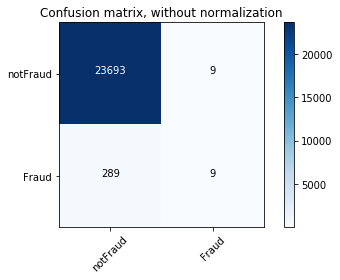

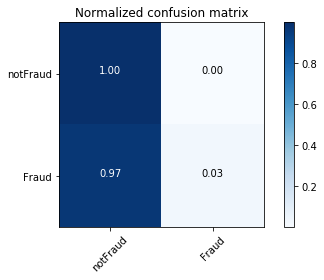

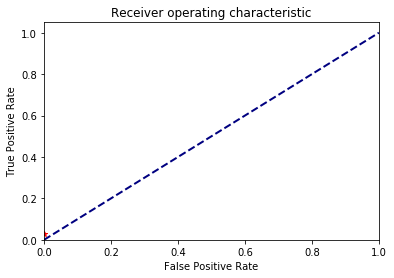

In [14]:
#calculating and plotting all nessessary plots and variables.
calculateAndPlot(yTrain,pred,class_names)

### 1.3 Using the model, test the test set, and report the testing confusion matrix, accuracy, precision, recall, F1-score, the ROC curve and the corresponding AUC score.

In [15]:
pred = predict(XTestWB, Weights)

TP = 1
TN = 5938
FP = 2
FN = 59
Acc = 0.99
rec = 0.02
prec = 0.33
f1 = 0.03
TPR = 0.02
FPR = 0.00
AUC = 0.51


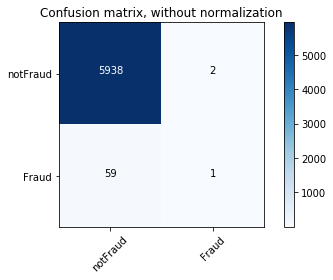

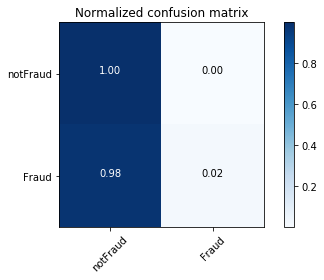

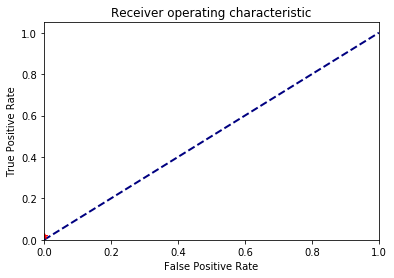

In [16]:
#calculating and plotting all nessessary plots and variables.
calculateAndPlot(yTest,pred,class_names)

### 1.4 Looking at results obtained in Tasks 1.2 and 1.3: Is your classifier showing any sign of overfitting, or underfitting? And explain why do you think that. If yes, can you suggest a solution, and utilize it to solve the issue (if present).

In [17]:
### since AUC for TRAINING AND TESTING is similar, there is not any sign of overfitting or underfitting.

### 1.5 (Graduate Student Requirement) Dataset follows a highly skewed distribution in terms of the target class label. Can you devise a workaround to this? Please explain and redo tasks 1.1, 1.2, 1.3, and 1.4.

In [18]:
XTrain, XTest, yTrain, yTest = train_test_split(X , y, test_size=0.2)

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(XTrain, yTrain)

#fit_transform use the statistics from given data and normalize it
scalar = StandardScaler()
scalar.fit(X_resampled)                    # using XTrain data to normalization

XTrain = scalar.transform(X_resampled)
XTest = scalar.transform(XTest)

XTrainWB = np.insert(XTrain, 0, values=1, axis=1)
XTestWB = np.insert(XTest, 0, values=1, axis=1)

yTrain = y_resampled

In [19]:
bestHyperPara = bestHPs(h_p)

Average loss: 0.403172312008284 for epoch: 100 Learning Rate: 0.01 and Batch Size: 32
Average loss: 0.33212906748608695 for epoch: 1000 Learning Rate: 0.5 and Batch Size: 128
Average loss: 0.3323788234953762 for epoch: 500 Learning Rate: 0.1 and Batch Size: 1028
Average loss: 0.3321466838148861 for epoch: 2000 Learning Rate: 0.05 and Batch Size: 64
Average loss: 0.33213058288258035 for epoch: 1500 Learning Rate: 0.3 and Batch Size: 256


In [20]:
# now train the data based one above parameters
Weights = np.zeros(XTrainWB.shape[1])  # initializing with all zerors
Weights = LGD_MinBatch(XTrainWB, yTrain, Weights, bestHyperPara[0], bestHyperPara[1], bestHyperPara[2])

TP = 21253
TN = 19869
FP = 3843
FN = 2459
Acc = 0.87
rec = 0.90
prec = 0.85
f1 = 0.87
TPR = 0.90
FPR = 0.16
AUC = 0.87


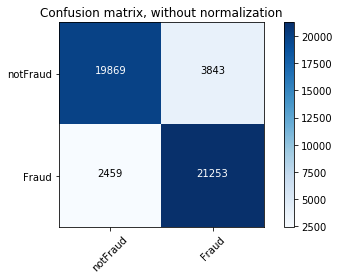

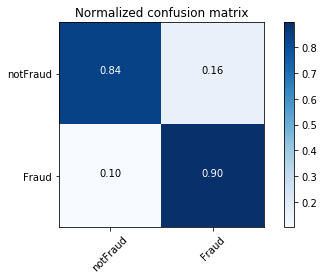

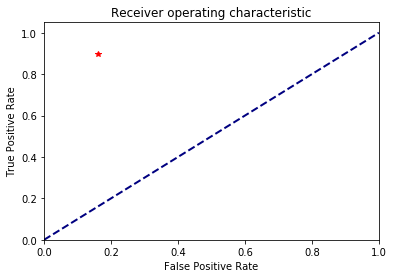

In [21]:
pred = predict(XTrainWB, Weights)

calculateAndPlot(yTrain,pred,class_names)

TP = 60
TN = 5016
FP = 914
FN = 10
Acc = 0.85
rec = 0.86
prec = 0.06
f1 = 0.11
TPR = 0.86
FPR = 0.15
AUC = 0.85


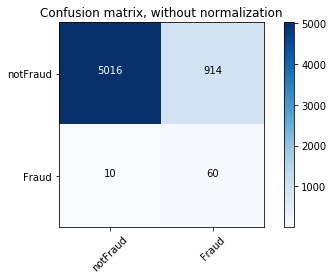

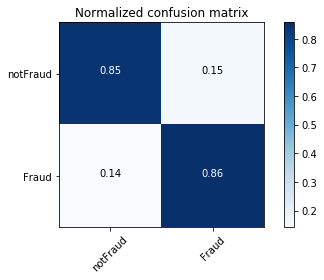

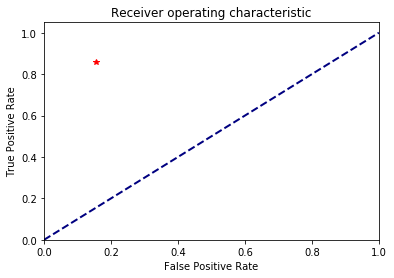

In [22]:
pred = predict(XTestWB, Weights)

calculateAndPlot(yTest,pred,class_names)

## Task 2 : Naive Bayes Classifier (NB)

In [61]:

def separateByClass(dataset, label):
    separated = {}
    for i in range(len(dataset)):
        vector = dataset[i]
        if(label[i] not in separated):
            separated[label[i]] = []
        separated[label[i]].append(vector)
    return separated

def summarize(dataset):
    summaries = [(np.mean(attribute), np.std(attribute)) for attribute in zip(*dataset)]
    return summaries

def summarizeByClass(dataset, label):
    separated = separateByClass(dataset, label)
    summaries = {}
    for classValue, instances in separated.items():
        summaries[classValue] = summarize(instances)
    return summaries

def calGaussianProb(x, mean, stdev):
    exponent = math.exp(-(math.pow(x-mean,2)/(2*math.pow(stdev,2))))
    return (1 / (math.sqrt(2*math.pi) * stdev)) * exponent

def calClassProba(summaries, inputVector):
    probabilities = {}
    for classValue, classSummaries in summaries.items():
        probabilities[classValue] = 1
        for i in range(len(classSummaries)):
            mean, stdev = classSummaries[i]
            x = inputVector[i]
            probabilities[classValue] *= calGaussianProb(x, mean, stdev)             
    return probabilities

def NaivePred(summaries, inputVector):
    probabilities = calClassProba(summaries, inputVector)
    bestLabel, bestProb = None, -1
    for classValue, probability in probabilities.items():
        if bestLabel is None or probability > bestProb:
            bestProb = probability
            bestLabel = classValue
    return bestLabel

def getPred(summaries, testSet):
    predictions = []
    for i in range(len(testSet)):
        result = NaivePred(summaries, testSet[i])
        predictions.append(result)
    return predictions

### 2.1 We do not have any hyper-parameters to train here. Then, simply report the 5-fold cross validation performance in terms of accuracy, precision, recall, F1-score. (On the training set)

In [64]:
datasetA = datasetA_OR
datasetATarget = datasetATarget_OR

#changing to array
X = datasetA.values
y = datasetATarget.values
y = y.flatten()

XTrain, XTest, yTrain, yTest = train_test_split(X , y, test_size=0.2)

yTest.flatten()
yTrain.flatten()

array([0, 0, 0, ..., 0, 0, 0])

In [65]:
kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(XTrain)  
kf.split(XTrain)                  #this works for target variables too

i = 0
for train_index, test_index in kf.split(XTrain):
    X_train, X_validation = XTrain[train_index], XTrain[test_index]
    y_train, y_validation = yTrain[train_index], yTrain[test_index]
    sepratedClass = summarizeByClass(X_train ,y_train)
    pred = getPred(sepratedClass, X_validation)
    print('\n' + str(i+1) + ' of 5-fold')
    printAPRF(y_validation, pred, class_names)
    i +=1


1 of 5-fold
Acc = 0.90
rec = 0.61
prec = 0.13
f1 = 0.21

2 of 5-fold
Acc = 0.90
rec = 0.58
prec = 0.12
f1 = 0.20

3 of 5-fold
Acc = 0.90
rec = 0.58
prec = 0.13
f1 = 0.21

4 of 5-fold
Acc = 0.90
rec = 0.55
prec = 0.11
f1 = 0.19

5 of 5-fold
Acc = 0.90
rec = 0.53
prec = 0.11
f1 = 0.19


### 2.2 Train the classifier on the training set, and report the training confusion matrix, accuracy, precision, recall, F1-score, the ROC curve and the corresponding AUC score.

TP = 942
TN = 67191
FP = 6904
FN = 708
Acc = 0.90
rec = 0.57
prec = 0.12
f1 = 0.20
TPR = 0.57
FPR = 0.09
AUC = 0.74


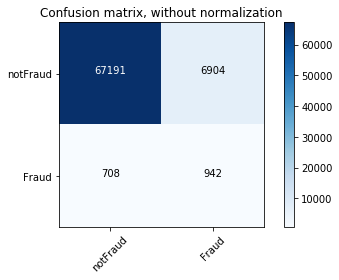

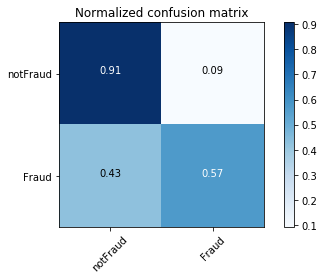

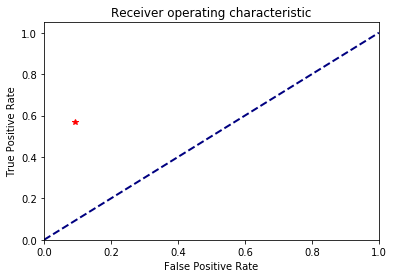

In [66]:
sepratedClass = summarizeByClass(XTrain ,yTrain)
pred = getPredictions(sepratedClass, XTrain)
calculateAndPlot(yTrain,pred,class_names)

### 2.3 Train the classifier on the training set, and report the training confusion matrix, accuracy, precision, recall, F1-score, the ROC curve and the corresponding AUC score.

TP = 237
TN = 16807
FP = 1686
FN = 207
Acc = 0.90
rec = 0.53
prec = 0.12
f1 = 0.20
TPR = 0.53
FPR = 0.09
AUC = 0.72


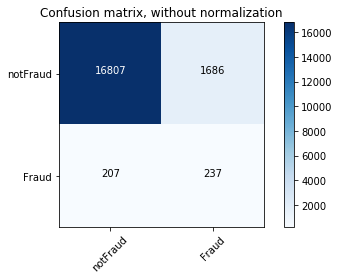

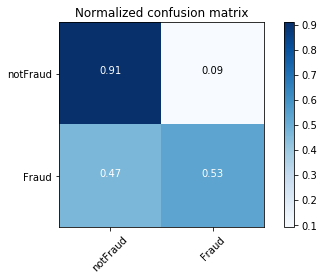

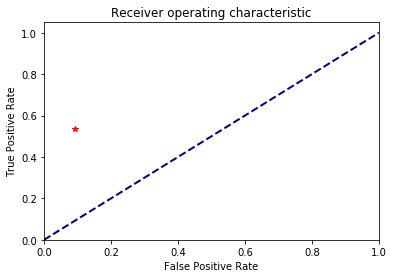

In [68]:
sepratedClass = summarizeByClass(XTrain ,yTrain)
pred = getPredictions(sepratedClass, XTest)
calculateAndPlot(yTest,pred,class_names)

### 2.4 Looking at results obtained in Tasks 1.2 and 1.3: Is your classifier showing any sign of overfitting, or underfitting? And explain why do you think that. If yes, can you suggest a solution, and utilize it to solve the issue (if present).

In [69]:
### since AUC for TRAINING AND TESTING is similar, there is not any sign of overfitting or underfitting.

### 2.5 (Graduate Student Requirement) Dataset follows a highly skewed distribution in terms of the target class label. Can you devise a workaround to this? Please explain and redo tasks 2.1, 2.2, 2.3, and 2.4.

In [77]:
# datasetA = datasetA.loc[range(0,7000)]
# datasetATarget = datasetATarget.loc[range(0,7000)]

#changing to array
X = datasetA.values
y = datasetATarget.values
y = y.flatten()

XTrain, XTest, yTrain, yTest = train_test_split(X , y, test_size=0.2)

ros = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(XTrain, yTrain)

yTest.flatten()
yTrain.flatten()

XTrain = preprocessing.normalize(X_resampled)
XTest = preprocessing.normalize(XTest)
yTrain = y_resampled

kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(XTrain)  
kf.split(XTrain)                  # this works for target variables too

i = 0
for train_index, test_index in kf.split(XTrain):
    X_train, X_validation = XTrain[train_index], XTrain[test_index]
    y_train, y_validation = yTrain[train_index], yTrain[test_index]
    sepratedClass = summarizeByClass(X_train ,y_train)
    pred = getPredictions(sepratedClass, X_validation)
    print('\n' + str(i+1) + ' of 5-fold')
    printAPRF(y_validation, pred, class_names)


1 of 5-fold
Acc = 0.53
rec = 0.05
prec = 0.89
f1 = 0.09

1 of 5-fold
Acc = 0.51
rec = 0.04
prec = 1.00
f1 = 0.08

1 of 5-fold
Acc = 0.51
rec = 0.06
prec = 0.58
f1 = 0.12

1 of 5-fold
Acc = 0.52
rec = 0.05
prec = 0.94
f1 = 0.09

1 of 5-fold
Acc = 0.53
rec = 0.07
prec = 0.83
f1 = 0.13


TP = 114
TN = 1606
FP = 36
FN = 1528
Acc = 0.52
rec = 0.07
prec = 0.76
f1 = 0.13
TPR = 0.07
FPR = 0.02
AUC = 0.52


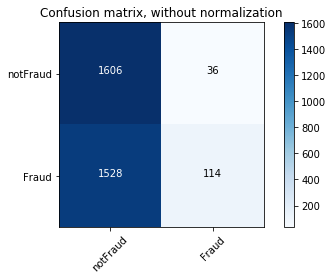

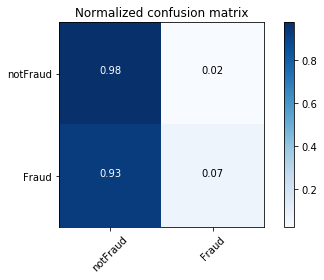

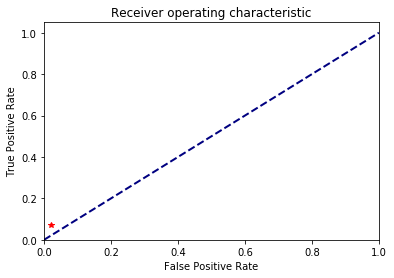

In [78]:
pred = getPredictions(sepratedClass, XTrain)
calculateAndPlot(yTrain,pred,class_names)

TP = 34
TN = 17983
FP = 502
FN = 418
Acc = 0.95
rec = 0.08
prec = 0.06
f1 = 0.07
TPR = 0.08
FPR = 0.03
AUC = 0.52


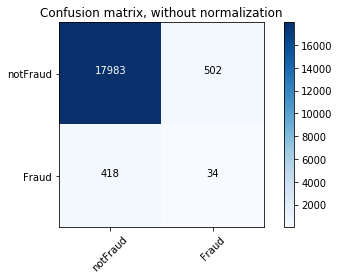

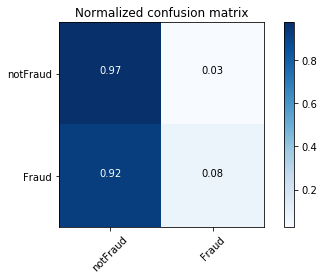

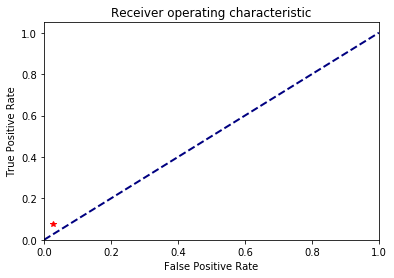

In [79]:
pred = getPredictions(sepratedClass, XTest)
calculateAndPlot(yTest,pred,class_names)

In [80]:
### since AUC for TRAINING AND TESTING is similar, there is not any sign of overfitting or underfitting.

## Task 3 : kNN Classifier (kNN)

In [34]:
datasetA = datasetA_OR.loc[range(0,3000)]
datasetATarget = datasetATarget_OR.loc[range(0,3000)]

#changing to array
X = datasetA.values
y = datasetATarget.values
y = y.flatten()

XTrain, XTest, yTrain, yTest = train_test_split(X , y, test_size=0.2)

yTest.flatten()
yTrain.flatten()

XTrain = preprocessing.normalize(XTrain)
XTest = preprocessing.normalize(XTest)

### 3.1 Use a 10-fold cross validation strategy to obtain the best hyper-parameter value of the k-NN classifier (i.e.,the value of k). Please report a discussion why you would choose the value. (On the training set)

In [35]:
def getKNeighbors(XTrain, yTrain, x, k):
    dstnc = []
    for xs in range(len(XTrain)):
        dist = np.linalg.norm(x - XTrain[xs])
        dstnc.append((XTrain[xs], yTrain[xs], dist))
    dstnc.sort(key=operator.itemgetter(2))
    kNeighbors = []
    for t in range(k):
        kNeighbors.append((dstnc[t][0], dstnc[t][1]))
    return kNeighbors

def predictFromKNN(XTrain,yTrain, XTest, k):
    pred = []
    for x in range(len(XTest)):
        ngbrs = getKNeighbors(XTrain,yTrain, XTest[x], k)
        ngbrs = np.asarray(ngbrs)
        allabel = ngbrs[:,1]
        unique, counts = np.unique(allabel, return_counts=True)
        maxpos = np.where(counts == max(counts))   
        pred.append(unique[maxpos[0][0]])
    return pred      

def bestHPs(XTrain, yTrain):
    besthp = 1
    minAvrERR = sys.maxsize
    for hp in range(3):
        # for epoch in range(5):
        kf = KFold(n_splits=10, shuffle=True)
        kf.get_n_splits(XTrain, yTrain)  
        kf.split(XTrain)                  # this works for target variables too
#         RMSEs = []
        MAEs = []
        for train_index, test_index in kf.split(XTrain):
            X_train, X_validation = XTrain[train_index], XTrain[test_index]
            y_train, y_validation = yTrain[train_index], yTrain[test_index]
            pred = predictFromKNN(X_train, y_train,X_validation,hp*2+1)
#             l_ = loss(np.asarray(pred),y_validation)
#             RMSEs.append(np.sqrt(np.mean((np.asarray(pred) - y_validation )**2)))
            MAEs.append(np.sum(np.abs(np.asarray(pred) - y_validation )))
#         currAvrERR = np.mean(RMSEs)
        currAvrERR = np.mean(MAEs)
        print('Average Error: '+ str(currAvrERR)+ ' for k: '+ str(hp*2+1)) 
        if (currAvrERR < minAvrERR):
            minAvrERR = currAvrERR
            bestHPs = hp*2+1
    return bestHPs

#         RMSEArr.append(np.sqrt(np.mean((pred - y_validation )**2)))
#     print('Average RMS Error: ' + str(np.mean(RMSEArr)))

In [36]:
bestHyper = bestHPs(XTrain, yTrain)

Average Error: 4.4 for k: 1
Average Error: 3.4 for k: 3
Average Error: 3.4 for k: 5


In [37]:
bestHyper = 5    # mannualy picking becasue all error are same

### 3.2 Train the classifier on the training set, and report the training confusion matrix, accuracy, precision, recall, F1-score, the ROC point on the ROC space.

In [38]:
pred = predictFromKNN(XTrain, yTrain,XTrain,bestHyper)

TP = 4
TN = 2365
FP = 2
FN = 29
Acc = 0.99
rec = 0.12
prec = 0.67
f1 = 0.21
TPR = 0.12
FPR = 0.00
AUC = 0.56


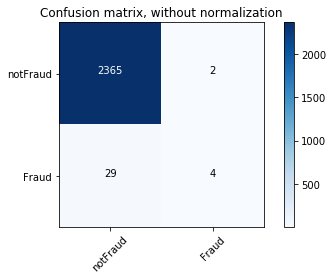

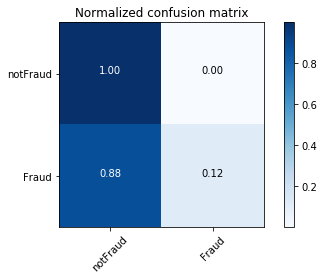

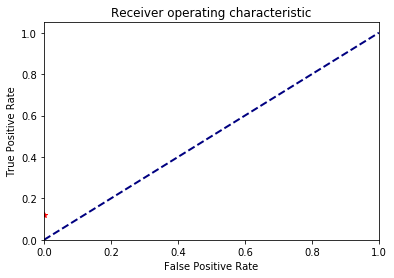

In [39]:
#calculating and plotting all nessessary plots and variables.
calculateAndPlot(yTrain,pred,class_names)

### 3.3 Using the model, test the test set, and report the testing confusion matrix, accuracy, precision, recall, F1-score, the ROC point on the ROC space.

In [40]:
pred = predictFromKNN(XTrain, yTrain,XTest,bestHyper)

In [41]:
yTest.shape

(600,)

TP = 0
TN = 590
FP = 0
FN = 10
Acc = 0.98
rec = 0.00
prec = 0.50
f1 = 0.00
TPR = 0.00
FPR = 0.00
AUC = 0.50


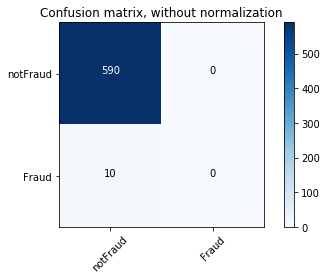

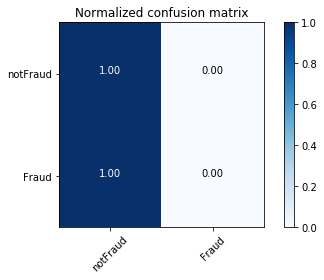

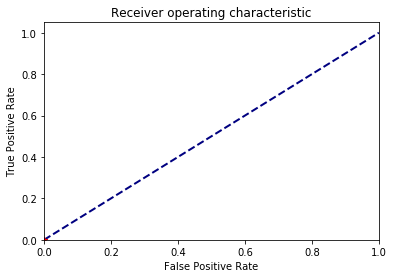

In [42]:
#calculating and plotting all nessessary plots and variables.
calculateAndPlot(yTest,pred,class_names)

### 3.4 Looking at results obtained in Tasks 1.2 and 1.3: Is your classifier showing any sign of overfitting, or underfitting? And explain why do you think that. If yes, can you suggest a solution, and utilize it to solve the issue (if present).

In [43]:
### k neighbour is not working properly becasue it not even once predicting the fruadlant behavior
### since AUC for TRAINING AND TESTING is similar, there is not any sign of overfitting or underfitting.

### 3.5 (Graduate Student Requirement) Dataset follows a highly skewed distribution in terms of the target class label. Can you devise a workaround to this? Please explain and redo tasks 1.1, 1.2, 1.3, and 1.4.

In [44]:
#using undersmapling to correct the skewness
XTrain, XTest, yTrain, yTest = train_test_split(X , y, test_size=0.2)

ros = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(XTrain, yTrain)

In [45]:
#fit_transform use the statistics from given data and normalize it
# scalar = StandardScaler()
# scalar.fit(X_resampled)                    # using XTrain data to normalization

# XTrain = scalar.transform(X_resampled)
# XTest = scalar.transform(XTest)

XTrain = preprocessing.normalize(X_resampled)
XTest = preprocessing.normalize(XTest)

# XTrainWB = np.insert(XTrain, 0, values=1, axis=1)
# XTestWB = np.insert(XTest, 0, values=1, axis=1)

yTrain = y_resampled

In [46]:
bestHyper = bestHPs(XTrain, yTrain)

Average Error: 1.2 for k: 1
Average Error: 1.4 for k: 3
Average Error: 1.6 for k: 5


In [47]:
bestHyper = 5

In [48]:
pred = predictFromKNN(XTrain, yTrain,XTrain,bestHyper)

TP = 25
TN = 24
FP = 6
FN = 5
Acc = 0.82
rec = 0.83
prec = 0.81
f1 = 0.82
TPR = 0.83
FPR = 0.20
AUC = 0.82


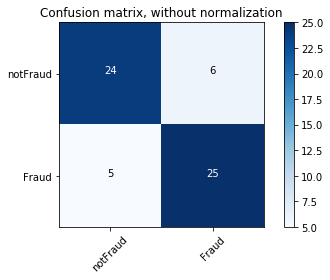

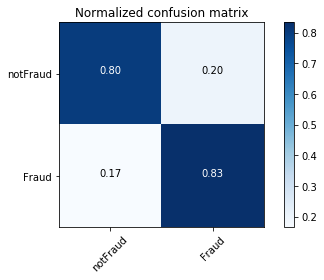

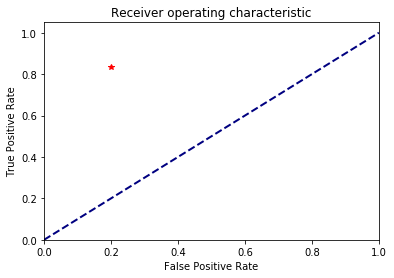

In [49]:
calculateAndPlot(yTrain,pred,class_names)

In [50]:
pred = predictFromKNN(XTrain, yTrain,XTest,bestHyper)

TP = 10
TN = 397
FP = 190
FN = 3
Acc = 0.68
rec = 0.77
prec = 0.05
f1 = 0.09
TPR = 0.77
FPR = 0.32
AUC = 0.72


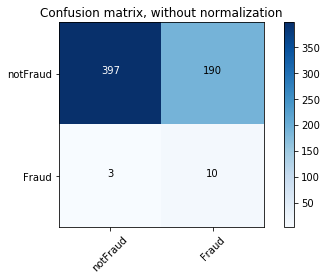

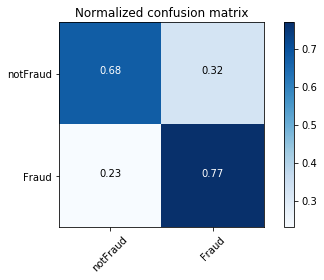

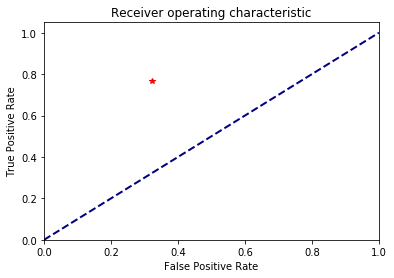

In [51]:
calculateAndPlot(yTest, pred, class_names)

## Task 4 : Comparing performances of LR, NB and kNN classifiers

### 4.1 The CoinBank manager asks you to choose one classifier for her which is less likely to miss any fraudulent transaction. With the help of a cost matrix, can you suggest her the best classifier from the three you developed in Task 1, 2 and 3? Which one would you pick, and why?

* we are assuming only FN has negetive cost
* After evaluating all three confusion matrix, linear regression has a lowest FN, Hence I would suggest here to choose
logistic regession model

### 4.2. CoinBank manager is also looking for an alternate classifier which will not make the legitimate customers angry due to the fact that the classifier you chose in Task 4.1 is going to raise a lot of false alarms. With the help of a cost matrix, can you suggest the best classifier from the three you developed? Which one would you pick, and why?

* we are assuming only "FP" has positive effect i.e. not sending false alarm
* After evaluating all three confusion matrix Naiive bayes model has lowest FP, Hence I would suggest here to choose
Naive bayes model

### 4.3 Which of the three classifiers do you think would be a balanced choice for CoinBank? And why?

* we are assuming only "FN" has negetive cost and "FP" has positive effect hence making bacance between these two is our goal
* After evaluating all three confusion matrix, KNN model balacned "FP" and "FN", Hence I would suggest here to choose
KNN model

# FOR SET B

In [121]:
#Load the CSV. And it does have a header
datasetA_OR = pd.read_csv('Set-B.X.csv')
datasetATarget_OR = pd.read_csv('Set-B.y.csv', header = None)

In [122]:
datasetA_OR.head()

,amount,hour1,state1,zip1,custAttr1,field1,custAttr2,field2,hour2,flag1,total,field3,field4,indicator1,indicator2,flag2,flag3,flag4,flag5
0,12.95,0,WA,986,1234567890123456,0,luhxsodzmjhng7@comcast.net,0,0,0,12.95,-723,19,0,0,0,0,0,1
1,38.85,0,WA,980,1234567890123457,3,pfixyiqfpvkcg@zjyxs.net,1,0,0,38.85,5497,14,1,0,0,1,0,1
2,38.85,0,KY,402,1234567890123458,2,shbjoldciswwm@aol.com,1,0,0,38.85,-4420,23,0,0,1,1,0,1
3,12.95,0,CA,958,1234567890123459,3,ipbvtdfkhhfws@sbcglobal.net,0,0,0,12.95,5010,31,0,0,1,0,0,1
4,38.85,0,GA,300,1234567890123460,3,ivfuvxiennhdp@bellsouth.net,1,0,0,38.85,-4074,21,0,0,1,0,0,1


In [123]:
datasetA_OR = datasetA_OR.drop(['custAttr1','custAttr2','state1','zip1'], axis=1)

In [124]:
datasetATarget_OR.head()

,0
0,0
1,0
2,0
3,0
4,0


## Task 1 : Logistic Regression based Classifier (LR)

In [125]:
datasetA = datasetA_OR.loc[range(0,30000)]
datasetATarget = datasetATarget_OR.loc[range(0,30000)]

#changing to array
X = datasetA.values
y = datasetATarget.values
y = y.flatten()

XTrain, XTest, yTrain, yTest = train_test_split(X , y, test_size=0.2)

yTest.flatten()
yTrain.flatten()

#fit_transform use the statistics from given data and normalize it
scalar = StandardScaler()
scalar.fit(XTrain)                    # using XTrain data to normalization

XTrain = scalar.transform(XTrain)
XTest = scalar.transform(XTest)

### 1.1 Use a 10-fold cross validation strategy to obtain the best set of hyper-parameter values of the logisticregression. Please report a discussion why you would choose the values. (On the training set)

In [126]:
def predict_probs(X, theta):
    return sigmoid(np.dot(X, theta))

def predict(X, theta, threshold=0.5):
    return predict_probs(X, theta) >= threshold

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def loss(h, y): 
    return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()

In [127]:
#defining logistic gradient_decent which will use the mini batch  

def LGD_MinBatch(XTrain, yTrain, thetas, epochs=1000, learningRate=0.5, batchSize = 128):
    theta= thetas
    m = len(XTrain)
    XRand = np.random.permutation(XTrain)
    yRand = np.random.permutation(yTrain)
    prevLoss = sys.maxsize
#     flg = False
    
    for it in range(epochs):
        for i in range (0,m, batchSize):
            XcurrBatch = XTrain[i:i+batchSize]
            ycurrBatch = yTrain[i:i+batchSize] 
            y_hat = np.dot(XcurrBatch,theta)
            h = sigmoid(y_hat)
            err = h - ycurrBatch.flatten()
            gradient = np.dot(XcurrBatch.T,err )
            theta = theta -  ((1/m) * learningRate * (gradient))
#         if(it % 100 == 0):
#             h_ = predict(XTrain, theta)
#             l_ = loss(h_,yTrain)
#             print(f'loss: ' + str(l_))
#             if abs(prevLoss - l_) > 0.000001:
#                 prevLoss = l_
#             else:
#                 flg = True  # it will break the epoch loop if it is no logner converging or convergin too slow
#         if flg:
#             break
    return theta

In [128]:
XTrainWB = np.insert(XTrain, 0, values=1, axis=1)
XTestWB = np.insert(XTest, 0, values=1, axis=1)

In [129]:
h_p = [[100,0.01,32],[1000,0.5,128],[500,0.1,1028],[2000,0.05,64],[1500,0.3,256]]

In [130]:
def bestHPs(hps):
    besthp = hps[0]
    minAvrLoss = sys.maxsize
    for hp in hps:
        Weights = np.zeros(XTrainWB.shape[1])
        # for epoch in range(5):
        kf = KFold(n_splits=10, shuffle=True)
        kf.get_n_splits(XTrainWB, yTrain)  
        kf.split(XTrainWB)                  # this works for target variables too
        ls = []
        for train_index, test_index in kf.split(XTrainWB):
            X_train, X_validation = XTrainWB[train_index], XTrainWB[test_index]
            y_train, y_validation = yTrain[train_index], yTrain[test_index]
            Weights = LGD_MinBatch(X_train, y_train, Weights,hp[0], hp[1], hp[2])
            pred_P = predict_probs(X_validation, Weights)
            l_ = loss(pred_P,y_validation)
            ls.append(l_)
        currAvrloss = np.mean(ls)
        print('Average loss: '+ str(currAvrloss)+ ' for epoch: '+ str(hp[0]) 
              + ' Learning Rate: '+ str(hp[1]) + ' and Batch Size: '+ str(hp[2]))
        if (currAvrloss < minAvrLoss):
            minAvrLoss = currAvrloss
            bestHPs = hp
    return bestHPs

#         RMSEArr.append(np.sqrt(np.mean((pred - y_validation )**2)))
#     print('Average RMS Error: ' + str(np.mean(RMSEArr)))

In [131]:
bestHyperPara = bestHPs(h_p)

Average loss: 0.2718792805551655 for epoch: 100 Learning Rate: 0.01 and Batch Size: 32
Average loss: 0.10034149472101124 for epoch: 1000 Learning Rate: 0.5 and Batch Size: 128
Average loss: 0.10039000403371914 for epoch: 500 Learning Rate: 0.1 and Batch Size: 1028
Average loss: 0.1004144957403228 for epoch: 2000 Learning Rate: 0.05 and Batch Size: 64
Average loss: 0.1003488907255728 for epoch: 1500 Learning Rate: 0.3 and Batch Size: 256


In [132]:
# now train the data based one above parameters
Weights = np.zeros(XTrainWB.shape[1])  # initializing with all zerors
Weights = LGD_MinBatch(XTrainWB, yTrain, Weights, bestHyperPara[0], bestHyperPara[1], bestHyperPara[2])

### 1.2 Train the classifier on the training set, and report the training confusion matrix, accuracy, precision, recall, F1-score, the ROC curve and the corresponding AUC score.

In [133]:
pred = predict(XTrainWB, Weights)

In [134]:
class_names = ['notFraud', 'Fraud']

In [135]:
def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#             print("Normalized confusion matrix\n============================")
#         else:
#             print('Confusion matrix, without normalization\n============================')

#         print(cm)
#         print("\n")

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()

def printAPRF(y,p,c_names):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
#     for i in range(len(yTest)):
    for i in range(len(y)):
        if y[i]==1 and p[i]==1:
            TP = TP + 1
        elif y[i]==0 and p[i]==0:
            TN = TN + 1
        elif y[i]==1 and p[i]==0:
            FN = FN + 1
        elif y[i]==0 and p[i]==1:
            FP = FP + 1
    if TP == 0:
        TP = 0.00000001
    if TN == 0:
        TN = 0.00000001
    if FP == 0:
        FP = 0.00000001
    if FN == 0:
        FN = 0.00000001
    acc = (TP+TN)/(TP+FP+TN+FN)
    print("Acc = %.2f" % acc)

    rec = TP/(TP+FN)
    print("rec = %.2f" % rec)

    prec = TP/(TP+FP)
    print("prec = %.2f" % prec)

    f1 = 2*prec*rec/(prec+rec)
    print("f1 = %.2f" %f1)
    
def calculateAndPlot(y,p,c_names):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
#     for i in range(len(yTest)):
    for i in range(len(p)):
        if y[i]==1 and p[i]==1:
            TP = TP + 1
        elif y[i]==0 and p[i]==0:
            TN = TN + 1
        elif y[i]==1 and p[i]==0:
            FN = FN + 1
        elif y[i]==0 and p[i]==1:
            FP = FP + 1
    if TP == 0:
        TP = 0.00000001
    if TN == 0:
        TN = 0.00000001
    if FP == 0:
        FP = 0.00000001
    if FN == 0:
        FN = 0.00000001
    print("TP = %.0f"%TP)
    print("TN = %.0f"%TN)
    print("FP = %.0f"%FP)
    print("FN = %.0f"%FN)


    acc = (TP+TN)/(TP+FP+TN+FN)
    print("Acc = %.2f" % acc)

    rec = TP/(TP+FN)
    print("rec = %.2f" % rec)

    prec = TP/(TP+FP)
    print("prec = %.2f" % prec)

    f1 = 2*prec*rec/(prec+rec)
    print("f1 = %.2f" %f1)

    TPR = TP/(TP+FN)
    print("TPR = %.2f" %TPR)

    FPR = FP/(FP+TN)
    print("FPR = %.2f" %FPR)
    
    AUC = roc_auc_score(y, p)
    print("AUC = %.2f" %AUC)

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_true=y, y_pred=p)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=c_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=c_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()
    
#     plt.title('ROC plot')
#     plt.xlabel('FPR')
#     plt.ylabel('TPR')
#     plt.plot(FPR,TPR,'*r')
#     plt.plot([0,1],[0,1], '--', )

    plt.figure()
    plt.plot(FPR, TPR, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % AUC)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.plot(FPR,TPR,'*r')
    plt.show()

TP = 127
TN = 23317
FP = 28
FN = 528
Acc = 0.98
rec = 0.19
prec = 0.82
f1 = 0.31
TPR = 0.19
FPR = 0.00
AUC = 0.60


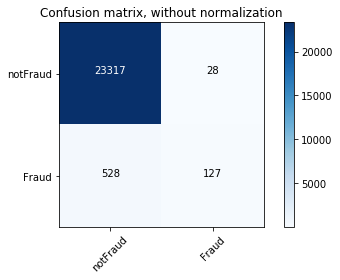

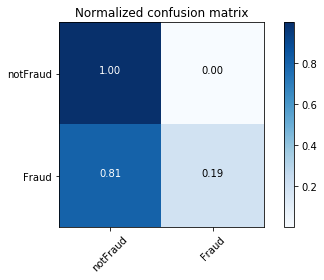

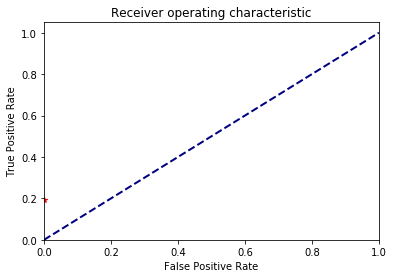

In [136]:
#calculating and plotting all nessessary plots and variables.
calculateAndPlot(yTrain,pred,class_names)

### 1.3 Using the model, test the test set, and report the testing confusion matrix, accuracy, precision, recall, F1-score, the ROC curve and the corresponding AUC score.

In [137]:
pred = predict(XTestWB, Weights)

TP = 26
TN = 5844
FP = 2
FN = 128
Acc = 0.98
rec = 0.17
prec = 0.93
f1 = 0.29
TPR = 0.17
FPR = 0.00
AUC = 0.58


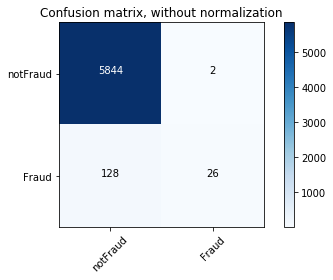

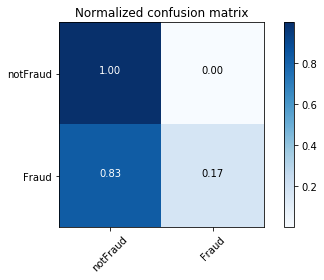

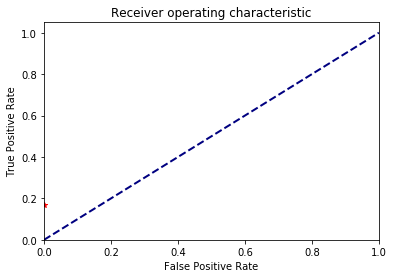

In [138]:
#calculating and plotting all nessessary plots and variables.
calculateAndPlot(yTest,pred,class_names)

### 1.4 Looking at results obtained in Tasks 1.2 and 1.3: Is your classifier showing any sign of overfitting, or underfitting? And explain why do you think that. If yes, can you suggest a solution, and utilize it to solve the issue (if present).

In [139]:
### since AUC for TRAINING AND TESTING is similar, there is not any sign of overfitting or underfitting.

### 1.5 (Graduate Student Requirement) Dataset follows a highly skewed distribution in terms of the target class label. Can you devise a workaround to this? Please explain and redo tasks 1.1, 1.2, 1.3, and 1.4.

In [140]:
XTrain, XTest, yTrain, yTest = train_test_split(X , y, test_size=0.2)

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(XTrain, yTrain)

#fit_transform use the statistics from given data and normalize it
scalar = StandardScaler()
scalar.fit(X_resampled)                    # using XTrain data to normalization

XTrain = scalar.transform(X_resampled)
XTest = scalar.transform(XTest)

XTrainWB = np.insert(XTrain, 0, values=1, axis=1)
XTestWB = np.insert(XTest, 0, values=1, axis=1)

yTrain = y_resampled

In [141]:
bestHyperPara = bestHPs(h_p)

Average loss: 0.5665742224476713 for epoch: 100 Learning Rate: 0.01 and Batch Size: 32
Average loss: 0.5210183234035566 for epoch: 1000 Learning Rate: 0.5 and Batch Size: 128
Average loss: 0.5269884426367984 for epoch: 500 Learning Rate: 0.1 and Batch Size: 1028
Average loss: 0.5236673433001635 for epoch: 2000 Learning Rate: 0.05 and Batch Size: 64
Average loss: 0.520377340231829 for epoch: 1500 Learning Rate: 0.3 and Batch Size: 256


In [142]:
# now train the data based one above parameters
Weights = np.zeros(XTrainWB.shape[1])  # initializing with all zerors
Weights = LGD_MinBatch(XTrainWB, yTrain, Weights, bestHyperPara[0], bestHyperPara[1], bestHyperPara[2])

TP = 16375
TN = 17332
FP = 6022
FN = 6979
Acc = 0.72
rec = 0.70
prec = 0.73
f1 = 0.72
TPR = 0.70
FPR = 0.26
AUC = 0.72


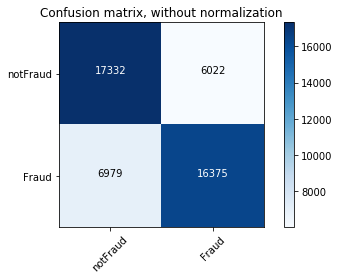

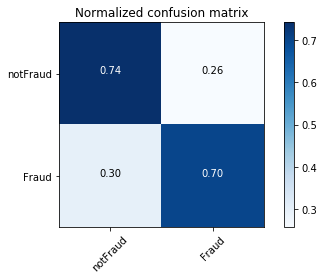

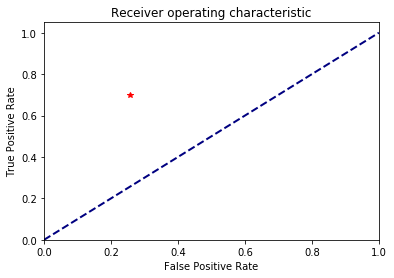

In [143]:
pred = predict(XTrainWB, Weights)

calculateAndPlot(yTrain,pred,class_names)

TP = 106
TN = 4344
FP = 1493
FN = 57
Acc = 0.74
rec = 0.65
prec = 0.07
f1 = 0.12
TPR = 0.65
FPR = 0.26
AUC = 0.70


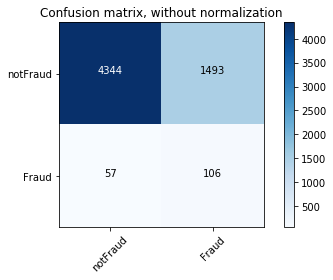

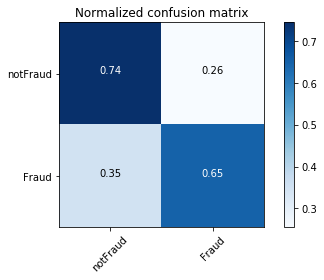

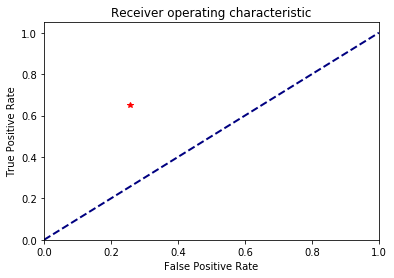

In [144]:
pred = predict(XTestWB, Weights)

calculateAndPlot(yTest,pred,class_names)

## Task 2 : Naive Bayes Classifier (NB)

In [161]:

def separateByClass(dataset, label):
    separated = {}
    for i in range(len(dataset)):
        vector = dataset[i]
        if(label[i] not in separated):
            separated[label[i]] = []
        separated[label[i]].append(vector)
    return separated

def summarize(dataset):
    summaries = [(np.mean(attribute), np.std(attribute)) for attribute in zip(*dataset)]
    return summaries

def summarizeByClass(dataset, label):
    separated = separateByClass(dataset, label)
    summaries = {}
    for classValue, instances in separated.items():
        summaries[classValue] = summarize(instances)
    return summaries

def calGaussianProb(x, mean, stdev):
    exponent = math.exp(-(math.pow(x-mean,2)/(2*math.pow(stdev,2))))
    return (1 / (math.sqrt(2*math.pi) * stdev)) * exponent

def calClassProba(summaries, inputVector):
    probabilities = {}
    for classValue, classSummaries in summaries.items():
        probabilities[classValue] = 1
        for i in range(len(classSummaries)):
            mean, stdev = classSummaries[i]
            x = inputVector[i]
            probabilities[classValue] *= calGaussianProb(x, mean, stdev)             
    return probabilities

def NaivePred(summaries, inputVector):
    probabilities = calClassProba(summaries, inputVector)
    bestLabel, bestProb = None, -1
    for classValue, probability in probabilities.items():
        if bestLabel is None or probability > bestProb:
            bestProb = probability
            bestLabel = classValue
    return bestLabel

def getPred(summaries, testSet):
    predictions = []
    for i in range(len(testSet)):
        result = NaivePred(summaries, testSet[i])
        predictions.append(result)
    return predictions

### 2.1 We do not have any hyper-parameters to train here. Then, simply report the 5-fold cross validation performance in terms of accuracy, precision, recall, F1-score. (On the training set)

In [162]:
datasetA = datasetA_OR
datasetATarget = datasetATarget_OR

#changing to array
X = datasetA.values
y = datasetATarget.values
y = y.flatten()

XTrain, XTest, yTrain, yTest = train_test_split(X , y, test_size=0.2)

yTest.flatten()
yTrain.flatten()

array([0, 0, 0, ..., 0, 0, 0])

In [163]:
kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(XTrain)  
kf.split(XTrain)                  #this works for target variables too

i = 0
for train_index, test_index in kf.split(XTrain):
    X_train, X_validation = XTrain[train_index], XTrain[test_index]
    y_train, y_validation = yTrain[train_index], yTrain[test_index]
    sepratedClass = summarizeByClass(X_train ,y_train)
    pred = getPred(sepratedClass, X_validation)
    print('\n' + str(i+1) + ' of 5-fold')
    printAPRF(y_validation, pred, class_names)
    i +=1


1 of 5-fold
Acc = 0.96
rec = 0.30
prec = 0.25
f1 = 0.27

2 of 5-fold
Acc = 0.96
rec = 0.33
prec = 0.27
f1 = 0.30

3 of 5-fold
Acc = 0.96
rec = 0.28
prec = 0.25
f1 = 0.26

4 of 5-fold
Acc = 0.96
rec = 0.35
prec = 0.29
f1 = 0.32

5 of 5-fold
Acc = 0.96
rec = 0.29
prec = 0.25
f1 = 0.26


### 2.2 Train the classifier on the training set, and report the training confusion matrix, accuracy, precision, recall, F1-score, the ROC curve and the corresponding AUC score.

TP = 662
TN = 76045
FP = 1818
FN = 1475
Acc = 0.96
rec = 0.31
prec = 0.27
f1 = 0.29
TPR = 0.31
FPR = 0.02
AUC = 0.64


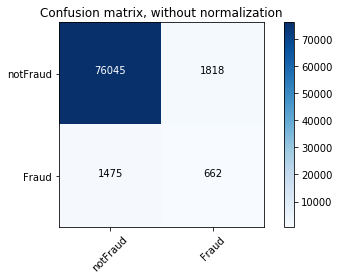

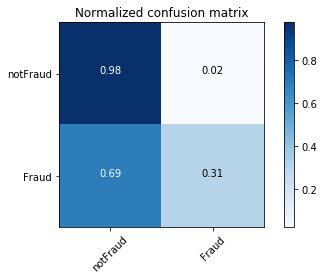

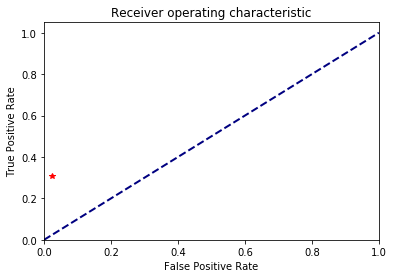

In [164]:
sepratedClass = summarizeByClass(XTrain ,yTrain)
pred = getPredictions(sepratedClass, XTrain)
calculateAndPlot(yTrain,pred,class_names)

### 2.3 Train the classifier on the training set, and report the training confusion matrix, accuracy, precision, recall, F1-score, the ROC curve and the corresponding AUC score.

TP = 173
TN = 19025
FP = 458
FN = 344
Acc = 0.96
rec = 0.33
prec = 0.27
f1 = 0.30
TPR = 0.33
FPR = 0.02
AUC = 0.66


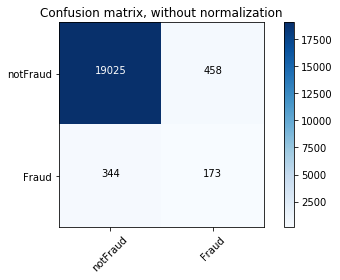

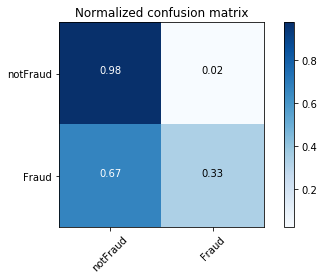

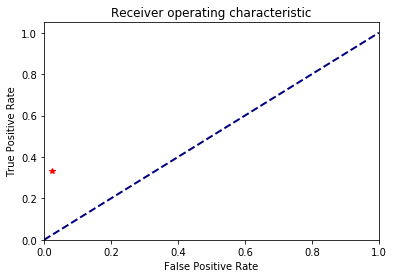

In [165]:
sepratedClass = summarizeByClass(XTrain ,yTrain)
pred = getPredictions(sepratedClass, XTest)
calculateAndPlot(yTest,pred,class_names)

### 2.4 Looking at results obtained in Tasks 1.2 and 1.3: Is your classifier showing any sign of overfitting, or underfitting? And explain why do you think that. If yes, can you suggest a solution, and utilize it to solve the issue (if present).

In [166]:
### since AUC for TRAINING AND TESTING is similar, there is not any sign of overfitting or underfitting.

### 2.5 (Graduate Student Requirement) Dataset follows a highly skewed distribution in terms of the target class label. Can you devise a workaround to this? Please explain and redo tasks 2.1, 2.2, 2.3, and 2.4.

In [167]:
# datasetA = datasetA.loc[range(0,7000)]
# datasetATarget = datasetATarget.loc[range(0,7000)]

#changing to array
X = datasetA.values
y = datasetATarget.values
y = y.flatten()

XTrain, XTest, yTrain, yTest = train_test_split(X , y, test_size=0.2)

ros = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(XTrain, yTrain)

yTest.flatten()
yTrain.flatten()

XTrain = preprocessing.normalize(X_resampled)
XTest = preprocessing.normalize(XTest)
yTrain = y_resampled

kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(XTrain)  
kf.split(XTrain)                  # this works for target variables too

i = 0
for train_index, test_index in kf.split(XTrain):
    X_train, X_validation = XTrain[train_index], XTrain[test_index]
    y_train, y_validation = yTrain[train_index], yTrain[test_index]
    sepratedClass = summarizeByClass(X_train ,y_train)
    pred = getPredictions(sepratedClass, X_validation)
    print('\n' + str(i+1) + ' of 5-fold')
    printAPRF(y_validation, pred, class_names)


1 of 5-fold
Acc = 0.63
rec = 0.29
prec = 0.97
f1 = 0.44

1 of 5-fold
Acc = 0.52
rec = 0.92
prec = 0.51
f1 = 0.66

1 of 5-fold
Acc = 0.54
rec = 0.89
prec = 0.53
f1 = 0.66

1 of 5-fold
Acc = 0.66
rec = 0.32
prec = 0.98
f1 = 0.48

1 of 5-fold
Acc = 0.66
rec = 0.29
prec = 0.99
f1 = 0.45


TP = 609
TN = 2126
FP = 7
FN = 1524
Acc = 0.64
rec = 0.29
prec = 0.99
f1 = 0.44
TPR = 0.29
FPR = 0.00
AUC = 0.64


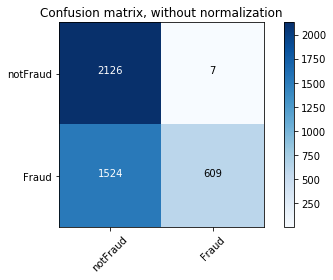

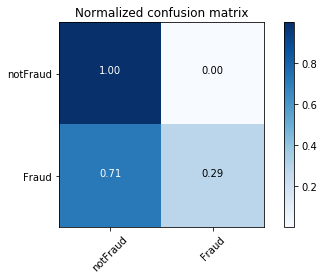

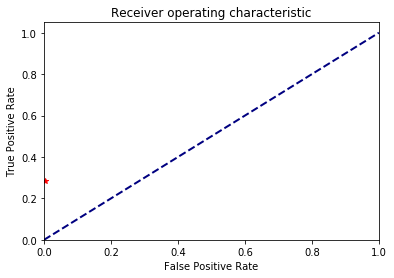

In [168]:
pred = getPredictions(sepratedClass, XTrain)
calculateAndPlot(yTrain,pred,class_names)

TP = 124
TN = 19378
FP = 101
FN = 397
Acc = 0.98
rec = 0.24
prec = 0.55
f1 = 0.33
TPR = 0.24
FPR = 0.01
AUC = 0.62


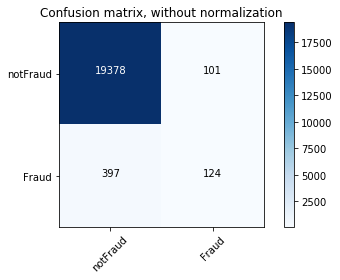

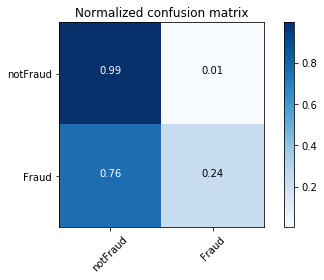

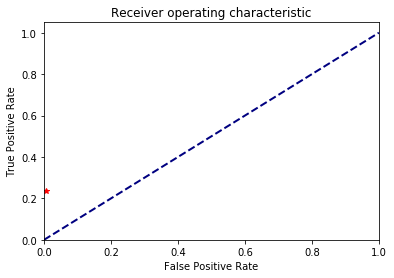

In [169]:
pred = getPredictions(sepratedClass, XTest)
calculateAndPlot(yTest,pred,class_names)

In [170]:
### since AUC for TRAINING AND TESTING is similar, there is not any sign of overfitting or underfitting.

## Task 3 : kNN Classifier (kNN)

In [171]:
datasetA = datasetA_OR.loc[range(0,3000)]
datasetATarget = datasetATarget_OR.loc[range(0,3000)]

#changing to array
X = datasetA.values
y = datasetATarget.values
y = y.flatten()

XTrain, XTest, yTrain, yTest = train_test_split(X , y, test_size=0.2)

yTest.flatten()
yTrain.flatten()

XTrain = preprocessing.normalize(XTrain)
XTest = preprocessing.normalize(XTest)

### 3.1 Use a 10-fold cross validation strategy to obtain the best hyper-parameter value of the k-NN classifier (i.e.,the value of k). Please report a discussion why you would choose the value. (On the training set)

In [174]:
def getKNeighbors(XTrain, yTrain, x, k):
    dstnc = []
    for xs in range(len(XTrain)):
        dist = np.linalg.norm(x - XTrain[xs])
        dstnc.append((XTrain[xs], yTrain[xs], dist))
    dstnc.sort(key=operator.itemgetter(2))
    kNeighbors = []
    for t in range(k):
        kNeighbors.append((dstnc[t][0], dstnc[t][1]))
    return kNeighbors

def predictFromKNN(XTrain,yTrain, XTest, k):
    pred = []
    for x in range(len(XTest)):
        ngbrs = getKNeighbors(XTrain,yTrain, XTest[x], k)
        ngbrs = np.asarray(ngbrs)
        allabel = ngbrs[:,1]
        unique, counts = np.unique(allabel, return_counts=True)
        maxpos = np.where(counts == max(counts))   
        pred.append(unique[maxpos[0][0]])
    return pred      

def bestHPs(XTrain, yTrain):
    besthp = 1
    minAvrERR = sys.maxsize
    for hp in range(4):
        # for epoch in range(5):
        kf = KFold(n_splits=10, shuffle=True)
        kf.get_n_splits(XTrain, yTrain)  
        kf.split(XTrain)                  # this works for target variables too
#         RMSEs = []
        MAEs = []
        for train_index, test_index in kf.split(XTrain):
            X_train, X_validation = XTrain[train_index], XTrain[test_index]
            y_train, y_validation = yTrain[train_index], yTrain[test_index]
            pred = predictFromKNN(X_train, y_train,X_validation,hp*2+1)
#             l_ = loss(np.asarray(pred),y_validation)
#             RMSEs.append(np.sqrt(np.mean((np.asarray(pred) - y_validation )**2)))
            MAEs.append(np.sum(np.abs(np.asarray(pred) - y_validation )))
#         currAvrERR = np.mean(RMSEs)
        currAvrERR = np.mean(MAEs)
        print('Average Error: '+ str(currAvrERR)+ ' for k: '+ str(hp*2+1)) 
        if (currAvrERR < minAvrERR):
            minAvrERR = currAvrERR
            bestHPs = hp*2+1
    return bestHPs

#         RMSEArr.append(np.sqrt(np.mean((pred - y_validation )**2)))
#     print('Average RMS Error: ' + str(np.mean(RMSEArr)))

In [175]:
bestHyper = bestHPs(XTrain, yTrain)

Average Error: 9.1 for k: 1
Average Error: 5.3 for k: 3
Average Error: 6.1 for k: 5
Average Error: 5.8 for k: 7


### 3.2 Train the classifier on the training set, and report the training confusion matrix, accuracy, precision, recall, F1-score, the ROC point on the ROC space.

In [176]:
pred = predictFromKNN(XTrain, yTrain,XTrain,bestHyper)

TP = 35
TN = 2320
FP = 5
FN = 40
Acc = 0.98
rec = 0.47
prec = 0.88
f1 = 0.61
TPR = 0.47
FPR = 0.00
AUC = 0.73


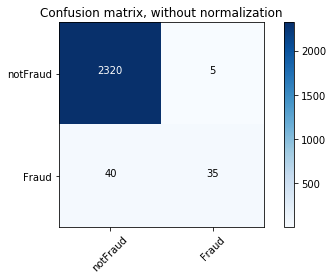

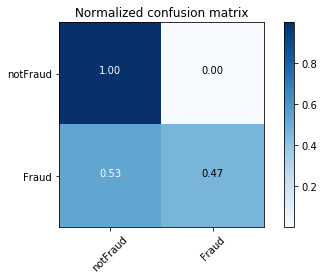

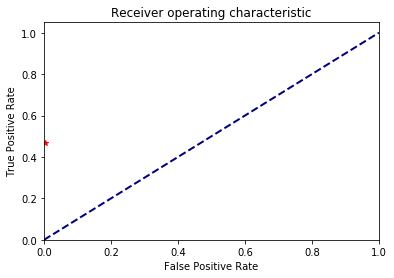

In [177]:
#calculating and plotting all nessessary plots and variables.
calculateAndPlot(yTrain,pred,class_names)

### 3.3 Using the model, test the test set, and report the testing confusion matrix, accuracy, precision, recall, F1-score, the ROC point on the ROC space.

In [178]:
pred = predictFromKNN(XTrain, yTrain,XTest,bestHyper)

In [179]:
yTest.shape

(600,)

TP = 7
TN = 585
FP = 1
FN = 7
Acc = 0.99
rec = 0.50
prec = 0.88
f1 = 0.64
TPR = 0.50
FPR = 0.00
AUC = 0.75


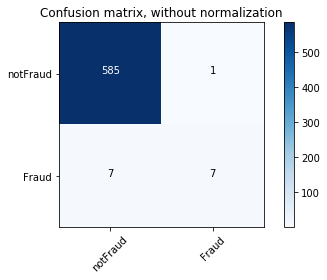

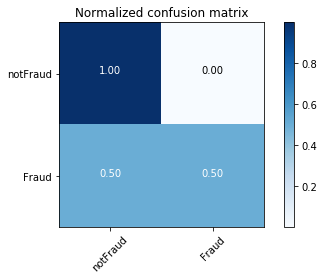

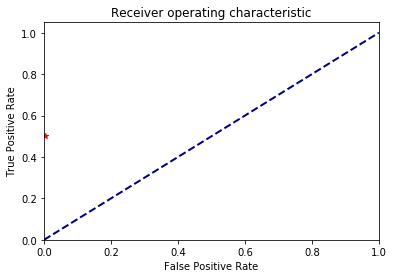

In [180]:
#calculating and plotting all nessessary plots and variables.
calculateAndPlot(yTest,pred,class_names)

### 3.4 Looking at results obtained in Tasks 1.2 and 1.3: Is your classifier showing any sign of overfitting, or underfitting? And explain why do you think that. If yes, can you suggest a solution, and utilize it to solve the issue (if present).

In [181]:
### k neighbour is not working properly becasue it not even once predicting the fruadlant behavior
### since AUC for TRAINING AND TESTING is similar, there is not any sign of overfitting or underfitting.

### 3.5 (Graduate Student Requirement) Dataset follows a highly skewed distribution in terms of the target class label. Can you devise a workaround to this? Please explain and redo tasks 1.1, 1.2, 1.3, and 1.4.

In [182]:
#using undersmapling to correct the skewness
XTrain, XTest, yTrain, yTest = train_test_split(X , y, test_size=0.2)

ros = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(XTrain, yTrain)

In [183]:
#fit_transform use the statistics from given data and normalize it
# scalar = StandardScaler()
# scalar.fit(X_resampled)                    # using XTrain data to normalization

# XTrain = scalar.transform(X_resampled)
# XTest = scalar.transform(XTest)

XTrain = preprocessing.normalize(X_resampled)
XTest = preprocessing.normalize(XTest)

# XTrainWB = np.insert(XTrain, 0, values=1, axis=1)
# XTestWB = np.insert(XTest, 0, values=1, axis=1)

yTrain = y_resampled

In [184]:
bestHyper = bestHPs(XTrain, yTrain)

Average Error: 4.8 for k: 1
Average Error: 4.7 for k: 3
Average Error: 5.1 for k: 5
Average Error: 4.8 for k: 7


In [185]:
pred = predictFromKNN(XTrain, yTrain,XTrain,bestHyper)

TP = 51
TN = 65
FP = 6
FN = 20
Acc = 0.82
rec = 0.72
prec = 0.89
f1 = 0.80
TPR = 0.72
FPR = 0.08
AUC = 0.82


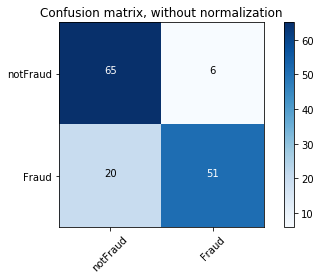

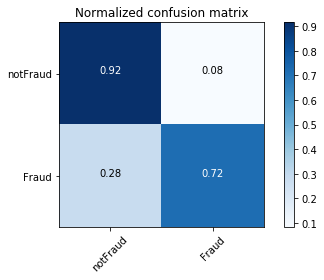

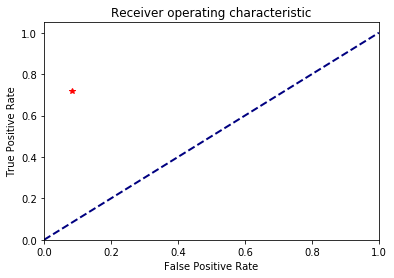

In [186]:
calculateAndPlot(yTrain,pred,class_names)

In [187]:
pred = predictFromKNN(XTrain, yTrain,XTest,bestHyper)

TP = 9
TN = 429
FP = 153
FN = 9
Acc = 0.73
rec = 0.50
prec = 0.06
f1 = 0.10
TPR = 0.50
FPR = 0.26
AUC = 0.62


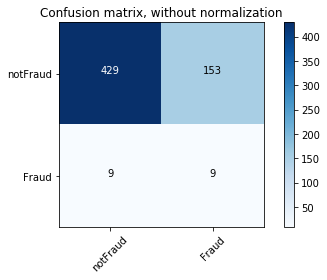

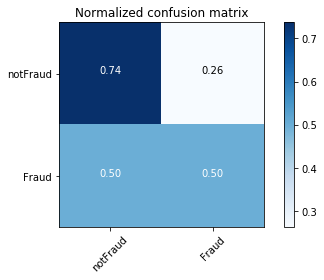

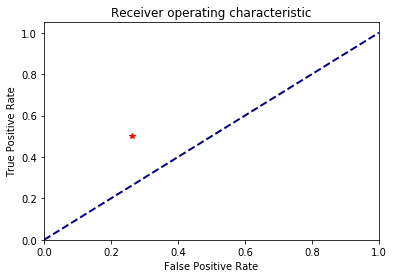

In [188]:
calculateAndPlot(yTest, pred, class_names)

## Task 4 : Comparing performances of LR, NB and kNN classifiers

### 4.1 The CoinBank manager asks you to choose one classifier for her which is less likely to miss any fraudulent transaction. With the help of a cost matrix, can you suggest her the best classifier from the three you developed in Task 1, 2 and 3? Which one would you pick, and why?

* we are assuming only FN has negetive cost
* After evaluating all three confusion matrix, linear regression has a lowest FN, Hence I would suggest here to choose
logistic regession model

### 4.2. CoinBank manager is also looking for an alternate classifier which will not make the legitimate customers angry due to the fact that the classifier you chose in Task 4.1 is going to raise a lot of false alarms. With the help of a cost matrix, can you suggest the best classifier from the three you developed? Which one would you pick, and why?

* we are assuming only "FP" has positive effect i.e. not sending false alarm
* After evaluating all three confusion matrix Naiive bayes model has lowest FP, Hence I would suggest here to choose
Naive bayes model

### 4.3 Which of the three classifiers do you think would be a balanced choice for CoinBank? And why?

* we are assuming only "FN" has negetive cost and "FP" has positive effect hence making bacance between these two is our goal
* After evaluating all three confusion matrix, KNN model balacned "FP" and "FN", Hence I would suggest here to choose
KNN model